# Иникатор: Полосы Боллинджера

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

В качестве данных возьмем цену BTC/USDT

<AxesSubplot:xlabel='time'>

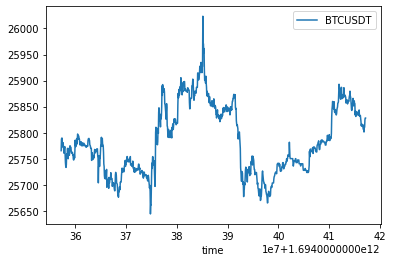

In [6]:
df=pd.read_pickle('binance_1m_till_1sep2023_merged/spot_1m.pkl').sort_index()[['BTCUSDT']].dropna()
df.iloc[-1000:].plot()

Индикатор представляет из себя скользяющую среднюю с некоторым периодом p, и две линии размещенные на расстоянии n стандартных отклонений (за период p) от скользящей средней. Для наглядности возьмем p=200, n=3

<AxesSubplot:xlabel='time'>

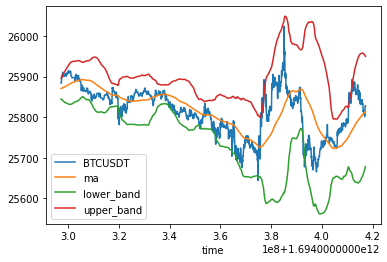

In [11]:
p=200
n=3
df['ma']=df['BTCUSDT'].rolling(p).mean()
df['std']=df['BTCUSDT'].rolling(p).std()
df['upper_band']=df['ma']+n*df['std']
df['lower_band']=df['ma']-n*df['std']

df[['BTCUSDT','ma','lower_band','upper_band']].iloc[-2000:].plot()

Если цена обладает свойствами возврата к среднему, то пересечение нижней полосы говорит о заниженной цене актива, верхней - о завышенной. 

## Принятие решения на основе индикатора

Попробуем открывать длинную позицию при выходе цены за нижнюю границу, открывать короткую позицию при выходе цены за верхнюю, а закрывать позиции при приходе цены к среднему значению.

<AxesSubplot:xlabel='time'>

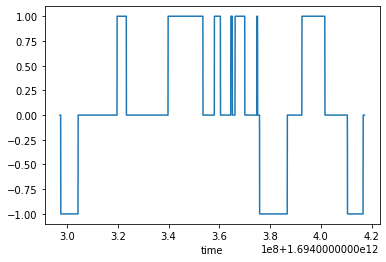

In [16]:
def make_positions(df,ticker='BTCUSDT'):
    long=df[ticker]<df['lower_band']
    long_out=df[ticker]>df['ma']
    
    short=df[ticker]>df['upper_band']
    short_out=df[ticker]<df['ma']
    
    #пока нет сигналов к открытию/закрытию позиции - сохраняем предыдущюю позицию
    long_pos=(1*long-1*long_out).replace(0,np.nan).ffill()*0.5+0.5
    short_pos=(1*short-1*short_out).replace(0,np.nan).ffill()*0.5+0.5
    
    #сложим длинную и короткую позиции
    pos=1*long_pos-1*short_pos
    return pos
pos=make_positions(df)
pos.iloc[-2000:].plot()

Мы получили позиции по инструменту, теперь можем посмотреть на гипотетический PnL при торговле по данной стратегии

<AxesSubplot:xlabel='time'>

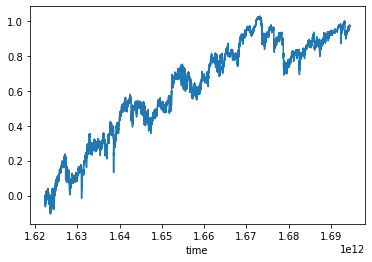

In [21]:
def make_pnl(df, pos,fee=0,ticker='BTCUSDT'):
    #следующее приращение цены
    next_pct_change=df[ticker].pct_change().shift(-1)
    
    #когда мы в длинной позиции - наша прибыль  повторяет профит от приобретения актива, 
    # когда в короткой, повторяет со знаком минус
    returns=pos*next_pct_change
    
    #вычтем коммиссии при входе и выходе из позиций
    returns-=pos.diff().abs()*fee
    
    #наш прирост виртуального баланса - кумулятивная сумма приростом за каждую минуту
    pnl=returns.cumsum()
    return pnl

pnl=make_pnl(df, pos,fee=0)
pnl.plot()

При нулевых комисииях получаем прибыль

<AxesSubplot:xlabel='time'>

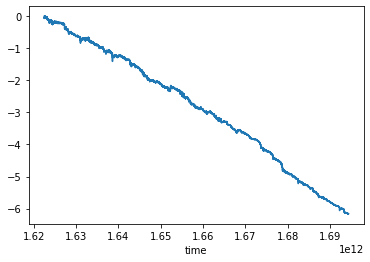

In [22]:

pnl=make_pnl(df, pos,fee=0.001)
pnl.plot()

При стандартных биржевых комиссиях получаем убыток

# Применяем ML

Попробуем предсказывать действие long/short/hold с помощью машинного обучения.
Для удобства преобразуем наш индикатор. Будем передавать в алгоритм ML полодение цены относительно нижней и верхней границы.


In [25]:
p=200
n=3
df['z']=(df['BTCUSDT']-df['BTCUSDT'].rolling(p).mean())/df['BTCUSDT'].rolling(p).std()

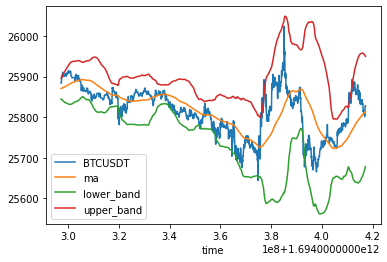

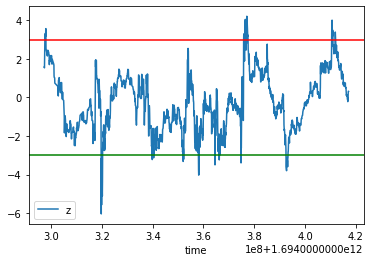

In [31]:
df[['BTCUSDT','ma','lower_band','upper_band']].iloc[-2000:].plot()
plt.show()
df[['z']].iloc[-2000:].plot()
plt.axhline(n,c='red')
plt.axhline(-n,c='green')

Можно заметить, что преобразованные значения соответствуют z-нормализации. Слдовательно пересечения верхней полосы Боллинджера соответствует превышению z-нормализованной цены значения n (которую мы использовали для построения лент Боллинджера)

## Сделаем тренировочный датасет

сделаем z-нормализацию с разными периодами, а в качесте таргета будем использовать цену через 2 часа. Если цена выше пороговых значений, то сигнал лонг(1), если ниже, то шорт(-1), иначе сигнал на выход из позиции (0)

In [41]:
#Определим пороговые значения
df['BTCUSDT'].pct_change(120)>0.027#.quantile([0.01,0.99])

time
1622415960000    False
1622416020000    False
1622416080000    False
1622416140000    False
1622416200000    False
                 ...  
1694416920000    False
1694416980000    False
1694417040000    False
1694417100000    False
1694417160000    False
Name: BTCUSDT, Length: 1199551, dtype: bool

In [42]:
def make_df(df,ticker='BTCUSDT'):
    for p in [20,50,100,200,400,800]:
        df[f'z{p}']=(df[ticker]-df[ticker].rolling(p).mean())/df[ticker].rolling(p).std()
    df['y']=1*(df[ticker].pct_change(120)>0.027)-1*(df[ticker].pct_change(120)<-0.027)
    return df
dataset=make_df(df,ticker='BTCUSDT')
dataset.tail()

,BTCUSDT,ma,std,upper_band,lower_band,z,z20,z50,z100,z200,z400,z800,y
time,,,,,,,,,,,,,
1694416920000,25810.60,25812.07525,46.803010,25952.484280,25671.666220,-0.031520,-0.829395,-1.431942,-1.916133,-0.031520,0.739812,0.276202,0
1694416980000,25810.59,25812.48915,46.418521,25951.744713,25673.233587,-0.040914,-0.747795,-1.380899,-1.861172,-0.040914,0.735638,0.274372,0
1694417040000,25824.51,25812.96620,46.045988,25951.104164,25674.828236,0.250702,0.495872,-0.641664,-1.192029,0.250702,0.971271,0.478550,0
1694417100000,25828.13,25813.46135,45.670534,25950.472952,25676.449748,0.321184,1.004781,-0.419939,-1.014201,0.321184,1.028751,0.530430,0
1694417160000,25828.13,25813.96295,45.274286,25949.785808,25678.140092,0.312916,1.051966,-0.387670,-1.004540,0.312916,1.024095,0.528757,0


In [44]:
#разделим на трейн, валидацию и тест
from sklearn.model_selection import train_test_split
train_,test=train_test_split(dataset,test_size=0.25,shuffle=False)
train,val=train_test_split(train_,test_size=0.15,shuffle=False)

In [46]:
#получим тренировочный набор и таргеты
def make_xy(df):
    X=df[[f'z{p}' for p in [20,50,100,200,400,800]]]
    y=df['y']
    return X,y
make_xy(train)
    

(                    z20       z50      z100      z200      z400      z800
 time                                                                     
 1622415960000       NaN       NaN       NaN       NaN       NaN       NaN
 1622416020000       NaN       NaN       NaN       NaN       NaN       NaN
 1622416080000       NaN       NaN       NaN       NaN       NaN       NaN
 1622416140000       NaN       NaN       NaN       NaN       NaN       NaN
 1622416200000       NaN       NaN       NaN       NaN       NaN       NaN
 ...                 ...       ...       ...       ...       ...       ...
 1668321840000 -0.063607 -1.085531 -1.788259 -1.960002 -2.108302 -1.518267
 1668321900000 -0.230448 -1.233542 -1.976984 -2.092813 -2.300732 -1.680293
 1668321960000 -1.218395 -1.814041 -2.694896 -2.607068 -2.946251 -2.246848
 1668322020000 -3.657042 -3.735096 -5.104791 -4.593032 -5.398131 -4.501653
 1668322080000 -2.579819 -3.129244 -4.352949 -4.209118 -5.063508 -4.276932
 
 [764713 rows x 6 colum

## В качестве модели МО будем использовать градиентный бустинг

In [48]:
from catboost import CatBoostClassifier

In [50]:
m=CatBoostClassifier(100)
m.fit(*make_xy(train),eval_set=make_xy(val))

Learning rate set to 0.297165
0:	learn: 0.6370055	test: 0.6205178	best: 0.6205178 (0)	total: 116ms	remaining: 11.4s
1:	learn: 0.4431103	test: 0.4184045	best: 0.4184045 (1)	total: 163ms	remaining: 7.98s
2:	learn: 0.3300224	test: 0.2999608	best: 0.2999608 (2)	total: 210ms	remaining: 6.78s
3:	learn: 0.2587840	test: 0.2236286	best: 0.2236286 (3)	total: 254ms	remaining: 6.09s
4:	learn: 0.2105432	test: 0.1717494	best: 0.1717494 (4)	total: 295ms	remaining: 5.61s
5:	learn: 0.1769142	test: 0.1356476	best: 0.1356476 (5)	total: 339ms	remaining: 5.31s
6:	learn: 0.1537116	test: 0.1101593	best: 0.1101593 (6)	total: 386ms	remaining: 5.12s
7:	learn: 0.1369866	test: 0.0918376	best: 0.0918376 (7)	total: 435ms	remaining: 5s
8:	learn: 0.1249626	test: 0.0784498	best: 0.0784498 (8)	total: 481ms	remaining: 4.87s
9:	learn: 0.1165093	test: 0.0686396	best: 0.0686396 (9)	total: 530ms	remaining: 4.77s
10:	learn: 0.1102418	test: 0.0616463	best: 0.0616463 (10)	total: 577ms	remaining: 4.67s
11:	learn: 0.1057363	test

95:	learn: 0.0866543	test: 0.0414341	best: 0.0413777 (52)	total: 4.57s	remaining: 190ms
96:	learn: 0.0866376	test: 0.0414412	best: 0.0413777 (52)	total: 4.61s	remaining: 143ms
97:	learn: 0.0866028	test: 0.0414501	best: 0.0413777 (52)	total: 4.65s	remaining: 95ms
98:	learn: 0.0865190	test: 0.0414047	best: 0.0413777 (52)	total: 4.7s	remaining: 47.5ms
99:	learn: 0.0865094	test: 0.0414054	best: 0.0413777 (52)	total: 4.75s	remaining: 0us

bestTest = 0.04137768026
bestIteration = 52

Shrink model to first 53 iterations.


Получим предсказания на валидационную выборку:

In [64]:
X_val,y_val=make_xy(val)
pred=pd.Series(m.predict(X_val)[:,0],X_val.index)
pred.value_counts()

 0    134587
 1       262
-1       101
dtype: int64

In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_val,pred))

              precision    recall  f1-score   support

          -1       0.32      0.15      0.21       207
           0       0.99      1.00      1.00    134095
           1       0.32      0.13      0.18       648

    accuracy                           0.99    134950
   macro avg       0.54      0.43      0.46    134950
weighted avg       0.99      0.99      0.99    134950



Получили неплохие результаты, получим предсказания на тестовую выборку

In [68]:
X_test,y_test=make_xy(test)
pred=pd.Series(m.predict(X_test)[:,0],X_test.index)
pred.value_counts()

 0    298822
 1       736
-1       330
dtype: int64

In [69]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

          -1       0.57      0.13      0.21      1430
           0       0.99      1.00      0.99    297073
           1       0.27      0.14      0.19      1385

    accuracy                           0.99    299888
   macro avg       0.61      0.42      0.46    299888
weighted avg       0.99      0.99      0.99    299888



### построим PnL

<AxesSubplot:xlabel='time'>

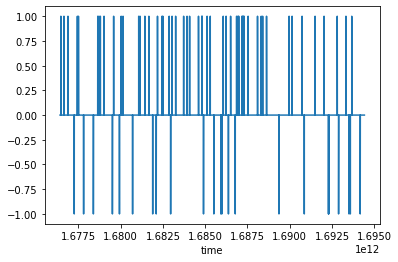

In [73]:
pos=pred

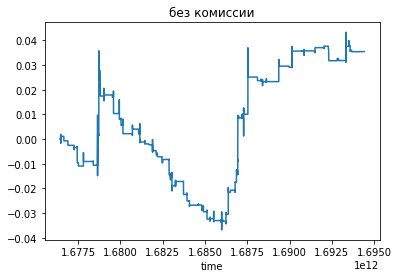

<AxesSubplot:title={'center':'стандартные комисиии'}, xlabel='time'>

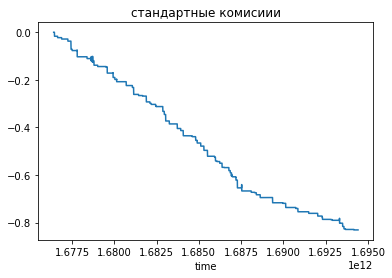

In [77]:
pnl=make_pnl(test, pos,fee=0.00)
plt.title('без комиссии')
pnl.plot()
plt.show()
pnl=make_pnl(test, pos,fee=0.001)
plt.title('стандартные комисиии')
pnl.plot()

### Мы так же получаем прибыль без учета комиссий, но с комиссиями уходим в минус

Попробуем изменить правила выхода из позиции, теперь будем выходит из позиции по прошествию минимум 120 минут, так как мы обучали алгоритм предсказывать цену через это время

<AxesSubplot:xlabel='time'>

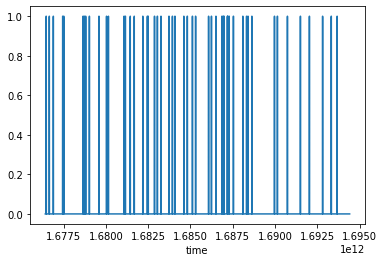

In [87]:
def make_ml_positions(pred):
    long=(pred>0).rolling(120).sum()>0
    short=(pred<0).rolling(120).sum()<0
    pos=1*long-1*short
    return pos

pos=make_ml_positions(pred)
pos.plot()

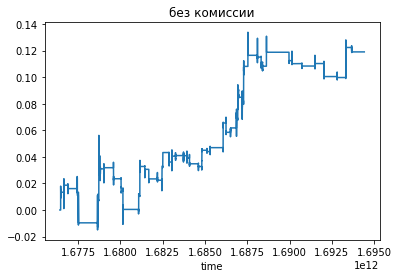

<AxesSubplot:title={'center':'стандартные комисиии'}, xlabel='time'>

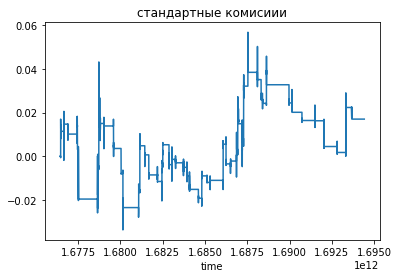

In [88]:
pnl=make_pnl(test, pos,fee=0.00)
plt.title('без комиссии')
pnl.plot()
plt.show()
pnl=make_pnl(test, pos,fee=0.001)
plt.title('стандартные комисиии')
pnl.plot()

## При таком подходе к вычислению позиции получили более отчетливую прибыль без комиссии, и вышли в плюс с учетом комиссии